In [1]:
import xarray as xr
import pandas as pd
import cytoolz as tz
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as f
from scipy.stats import poisson

In [18]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"))

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [19]:
# %% Load data
from pyspark.sql.types import *


print("Loading data...")
pdf = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
                gm2: {$gt: 0.005}
            },
        },
        {
            $project: {
                tag: true,
                gm2: true,
                nhits: {
                    $sum: {
                        $map: {
                            input: "$hits",
                            as: "h",
                            in: {$cond: {if: {$and: [{$gte: ["$$h.t", 7360]},  /* CHHII+ */
                                                     {$lt: ["$$h.t", 7440]}
                                                     {$lte: ["$$h.flag", 14]}]}, then: 1, else: 0}},
                        },                    
                    }
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("gm2", DoubleType()),
            StructField("nhits", LongType())
        ])
    )
    .load()
    .toPandas()
)
pdf.head()

Loading data...


,tag,gm2,nhits
0,158648231,0.009929,0
1,158648232,0.008909,0
2,158648233,0.009239,0
3,158648234,0.009721,0
4,158648235,0.007615,0


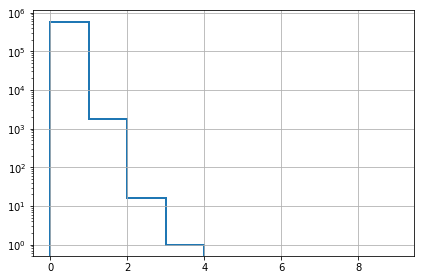

In [20]:
plt.figure()
plt.hist(pdf["nhits"], bins=np.arange(0, 10, 1), histtype="step", linewidth=2)
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

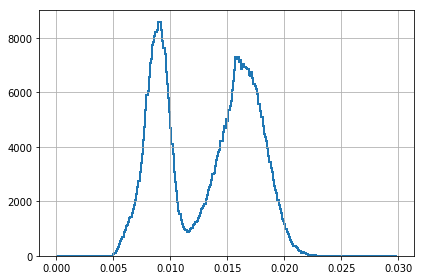

In [21]:
plt.figure()
plt.hist(pdf["gm2"], bins=np.arange(0, 0.03, 0.0001), histtype="step", linewidth=2)
plt.grid(True)
plt.tight_layout()
plt.show()

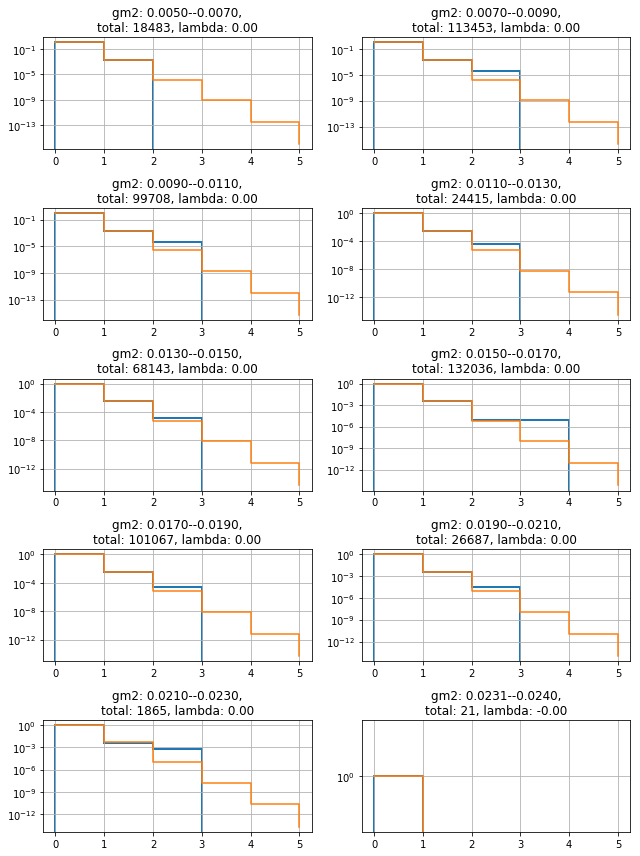

In [22]:
plt.figure(figsize=(9, 12))
for i, d in pdf.groupby(pdf["gm2"].apply(np.digitize, bins=np.arange(0.005, 0.025, 0.002))):
    total = len(d.index)
    mu = -np.log((d["nhits"] == 0).sum() / total)
    n = 6
    x = np.arange(n)
    y = poisson.pmf(x, mu)
    plt.subplot(5, 2, i)
    plt.title('gm2: {min:.4f}--{max:.4f},\ntotal: {total}, lambda: {mu:.2f}'.format(
        total=total,
        min=d["gm2"].min(),
        max=d["gm2"].max(),
        mu=mu))
    plt.hist(
        d["nhits"],
        bins=np.arange(0, n, 1),
        density=True,
        histtype="step",
        linewidth=2)
    plt.step(x, y, where="post")
    plt.grid(True)
    plt.yscale("log")
plt.tight_layout()
plt.show()

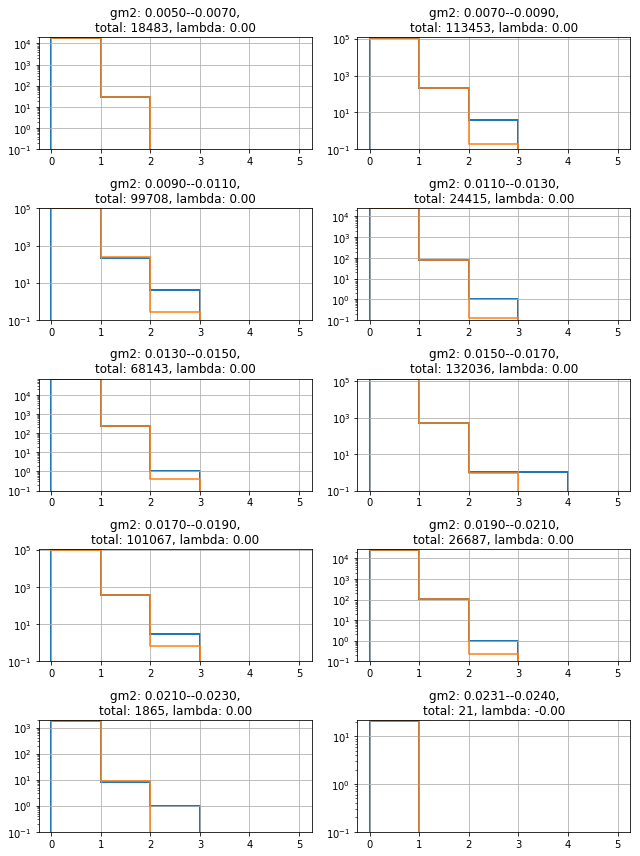

In [23]:
plt.figure(figsize=(9, 12))
for i, d in pdf.groupby(pdf["gm2"].apply(np.digitize, bins=np.arange(0.005, 0.025, 0.002))):
    total = len(d.index)
    mu = -np.log((d["nhits"] == 0).sum() / total)
    n = 6
    x = np.arange(n)
    y = poisson.pmf(x, mu)
    plt.subplot(5, 2, i)
    plt.title('gm2: {min:.4f}--{max:.4f},\ntotal: {total}, lambda: {mu:.2f}'.format(
        total=total,
        min=d["gm2"].min(),
        max=d["gm2"].max(),
        mu=mu))
    plt.hist(
        d["nhits"],
        bins=np.arange(0, n, 1),
        # density=True,
        histtype="step",
        linewidth=2)
    plt.step(x, total * y, where="post")
    plt.grid(True)
    plt.ylim(0.1, None)
    plt.yscale("log")
plt.tight_layout()
plt.show()